## Going Deeper - Segmentation 

U-Net을 통한 시맨틱 세그멘테이션 결과가 충분히 만족스러우신가요? 
어느정도 동작하는 것 같긴 하지만 좀더 개선할 여지도 보일 것입니다.

2018년에 U-Net++라는 논문이 나왔습니다.
이 논문은 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 
가미하여 성능을 개선한 모델입니다.

그래서 모델의 구조 자체는 아래 그림에서 보는 것처럼 별다른 설명이 없이도 직관적으로 이해가 가능한 수준입니다.
오늘 소개되었던 U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있을 것입니다.
그래서 오늘의 과제는 바로 U-Net++ 모델을 스스로의 힘으로 직접 구현해 보고, 
U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것입니다. 
정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 
정량적으로는 동일 이미지에 대한 IoU값을 비교해 보면 될 것입니다. 

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


In [4]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

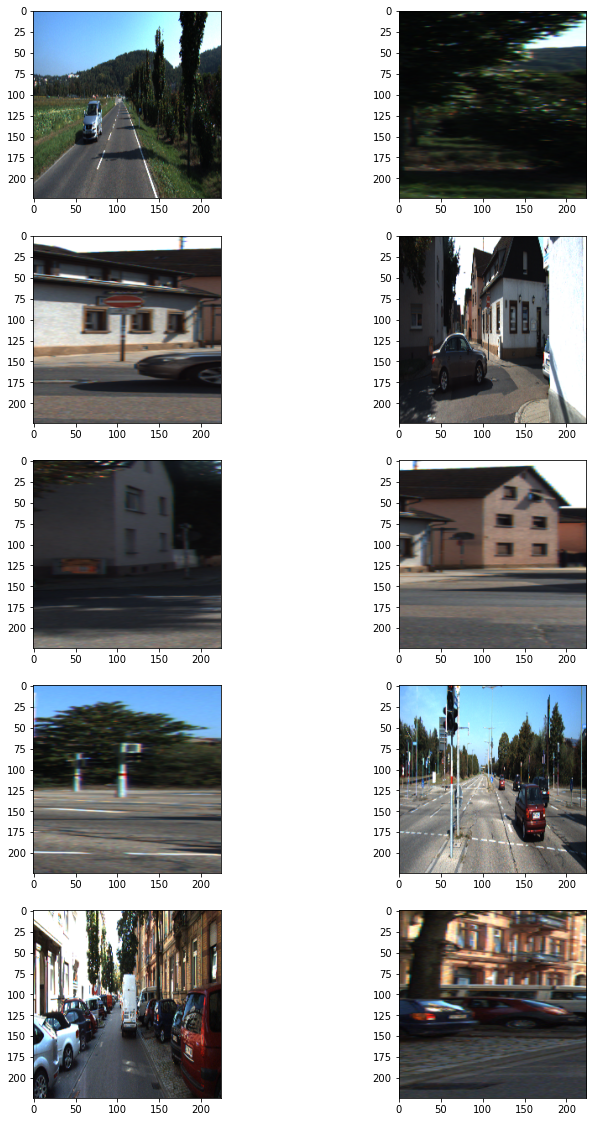

In [5]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [49]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [50]:
def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = target[2] - refer[2]
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = target[1] - refer[1]
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

In [51]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [19]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 6s 545ms/step - loss: 0.6929 - val_loss: 0.6926
Epoch 2/100
11/11 [==============================] - 6s 552ms/step - loss: 0.6924 - val_loss: 0.6921
Epoch 3/100
11/11 [==============================] - 6s 540ms/step - loss: 0.6919 - val_loss: 0.6916
Epoch 4/100
11/11 [==============================] - 6s 528ms/step - loss: 0.6913 - val_loss: 0.6910
Epoch 5/100
11/11 [==============================] - 6s 541ms/step - loss: 0.6907 - val_loss: 0.6900
Epoch 6/100
11/11 [==============================] - 6s 539ms/step - loss: 0.7069 - val_loss: 0.6900
Epoch 7/100
11/11 [==============================] - 6s 512ms/step - loss: 0.6897 - val_loss: 0.6894
Epoch 8/100
11/11 [==============================] - 6s 507ms/step - loss: 0.6892 - val_loss: 0.6889
Epoch 9/100
11/11 [==============================] - 6s 508ms/step - loss: 0.6886 - val_loss: 0.6884
Epoch 10/100
11/11 [==============================] - 6s 554ms/step - loss: 0.6881 - val_lo

11/11 [==============================] - 6s 514ms/step - loss: 0.6499 - val_loss: 0.6515
Epoch 80/100
11/11 [==============================] - 6s 512ms/step - loss: 0.6479 - val_loss: 0.6498
Epoch 81/100
11/11 [==============================] - 6s 512ms/step - loss: 0.6517 - val_loss: 0.6515
Epoch 82/100
11/11 [==============================] - 6s 512ms/step - loss: 0.6507 - val_loss: 0.6510
Epoch 83/100
11/11 [==============================] - 6s 512ms/step - loss: 0.6504 - val_loss: 0.6505
Epoch 84/100
11/11 [==============================] - 6s 513ms/step - loss: 0.6499 - val_loss: 0.6500
Epoch 85/100
11/11 [==============================] - 6s 513ms/step - loss: 0.6490 - val_loss: 0.6489
Epoch 86/100
11/11 [==============================] - 6s 513ms/step - loss: 0.6473 - val_loss: 0.6474
Epoch 87/100
11/11 [==============================] - 6s 513ms/step - loss: 0.6448 - val_loss: 0.6457
Epoch 88/100
11/11 [==============================] - 6s 513ms/step - loss: 0.6461 - val_loss: 

In [52]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output


In [53]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [61]:
def Unet_model(input_shape=(224, 224, 3), filters= [64, 128, 256, 512, 1024], kernel=3):
    inputs = Input(input_shape)
    x = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv1')(inputs)
    b1 = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b2_pool')(b1)
    x = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b2_conv1')(x)
    b2 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b2_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b3_pool')(b2)
    x = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b3_conv1')(x)
    b3 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b3_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b4_pool')(b3)
    x = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b4_conv1')(x)
    b4 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b4_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b5_pool')(b4)
    x = Dropout(0.5)(x)
    x = Conv2D(filters[4], kernel, activation='relu', padding='same',kernel_initializer='he_normal', name='b5_conv1')(x)
    
    x = Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding='valid', name='u1_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b4), int_shape(x))
    r1 = Cropping2D(cropping=(ch, cw), name='u1_resize')(b4)
    x = concatenate([r1,x], axis = 3, name='u1_merge')
    x = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u1_conv1')(x)
    x = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u1_conv2')(x)
    
    x = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b3), int_shape(x))
    r2 = Cropping2D(cropping=(ch, cw), name='u2_resize')(b3)
    x = concatenate([r2,x], axis = 3, name='u2_merge')
    x = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u2_conv1')(x)
    x = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u2_conv2')(x)
    
    x = Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), padding='valid', name='u3_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b2), int_shape(x))
    r3 = Cropping2D(cropping=(ch, cw), name='u3_resize')(b2)
    x = concatenate([r3,x], axis = 3, name='u3_merge')
    x = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u3_conv1')(x)
    x = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u3_conv2')(x)
    
    x = Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), padding='valid', name='u4_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b1), int_shape(x))
    r4 = Cropping2D(cropping=(ch, cw ), name='u4_resize')(b1)
    x = concatenate([r4,x], axis = 3, name='u4_merge')
    x = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u4_conv1')(x)
    x = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u4_conv2')(x)
    x = Conv2D(2, kernel, activation='relu', padding='same',kernel_initializer='he_normal', name='u4_conv3')(x)
    x = Conv2D(1, 1, activation='sigmoid')(x)
    output = tf.image.resize(x, (inputs.shape[1], inputs.shape[2]), name='output')
    
    model = Model(inputs = inputs, outputs = output)
    return model

In [62]:
def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = target[2] - refer[2]
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = target[1] - refer[1]
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

In [63]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [64]:
def Unet_model(input_shape=(224, 224, 3), filters= [64, 128, 256, 512, 1024], kernel=3):
    inputs = Input(input_shape)
    x = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv1')(inputs)
    b1 = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b1_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b2_pool')(b1)
    x = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b2_conv1')(x)
    b2 = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b2_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b3_pool')(b2)
    x = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b3_conv1')(x)
    b3 = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b3_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b4_pool')(b3)
    x = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b4_conv1')(x)
    b4 = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='b4_conv2')(x)
    
    x = MaxPooling2D(pool_size=(2,2), name='b5_pool')(b4)
    x = Dropout(0.5)(x)
    x = Conv2D(filters[4], kernel, activation='relu', padding='same',kernel_initializer='he_normal', name='b5_conv1')(x)
    
    x = Conv2DTranspose(filters[3], (2, 2), strides=(2, 2), padding='valid', name='u1_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b4), int_shape(x))
    r1 = Cropping2D(cropping=(ch, cw), name='u1_resize')(b4)
    x = concatenate([r1,x], axis = 3, name='u1_merge')
    x = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u1_conv1')(x)
    x = Conv2D(filters[3], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u1_conv2')(x)
    
    x = Conv2DTranspose(filters[2], (2, 2), strides=(2, 2), padding='valid', name='u2_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b3), int_shape(x))
    r2 = Cropping2D(cropping=(ch, cw), name='u2_resize')(b3)
    x = concatenate([r2,x], axis = 3, name='u2_merge')
    x = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u2_conv1')(x)
    x = Conv2D(filters[2], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u2_conv2')(x)
    
    x = Conv2DTranspose(filters[1], (2, 2), strides=(2, 2), padding='valid', name='u3_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b2), int_shape(x))
    r3 = Cropping2D(cropping=(ch, cw), name='u3_resize')(b2)
    x = concatenate([r3,x], axis = 3, name='u3_merge')
    x = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u3_conv1')(x)
    x = Conv2D(filters[1], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u3_conv2')(x)
    
    x = Conv2DTranspose(filters[0], (2, 2), strides=(2, 2), padding='valid', name='u4_convTran')(x)
    ch, cw = get_crop_shape(int_shape(b1), int_shape(x))
    r4 = Cropping2D(cropping=(ch, cw ), name='u4_resize')(b1)
    x = concatenate([r4,x], axis = 3, name='u4_merge')
    x = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u4_conv1')(x)
    x = Conv2D(filters[0], kernel, activation='relu', padding='valid',kernel_initializer='he_normal', name='u4_conv2')(x)
    x = Conv2D(2, kernel, activation='relu', padding='same',kernel_initializer='he_normal', name='u4_conv3')(x)
    x = Conv2D(1, 1, activation='sigmoid')(x)
    output = tf.image.resize(x, (inputs.shape[1], inputs.shape[2]), name='output')
    
    model = Model(inputs = inputs, outputs = output)
    return model

In [ ]:
u_model = Unet_model()
u_model.summary()

In [ ]:
u_model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
history = u_model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5'
u_model.save(model_path)  #학습한 모델을 저장해 주세요.

In [68]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 5    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.401479


0.4014794401334397

In [67]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 0    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.615828


0.6158279904151286

In [65]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.690421


0.6904207308196244

### 프로젝트를 마치며..

segmentation이 생각보다 많은  곳에 사용된다는 생각을 하게 되었다. 정신없이 마무리하게 되었다ㅠㅠ 
90이상이 되어야 하는뎅 그정도까진 끌어올리지 못했당
i = n 을 바꿔보았을때 오히려 많이 떨어지거나 약간 올라가는 것을 보았다. 